In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image 
import matplotlib
%matplotlib inline
matplotlib.rc('image', cmap = 'gray')

In [2]:
import cv2
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

In [41]:
print(dictionary)

< cv2.aruco.Dictionary 00000273723627B0>


(-0.5, 199.5, 199.5, -0.5)

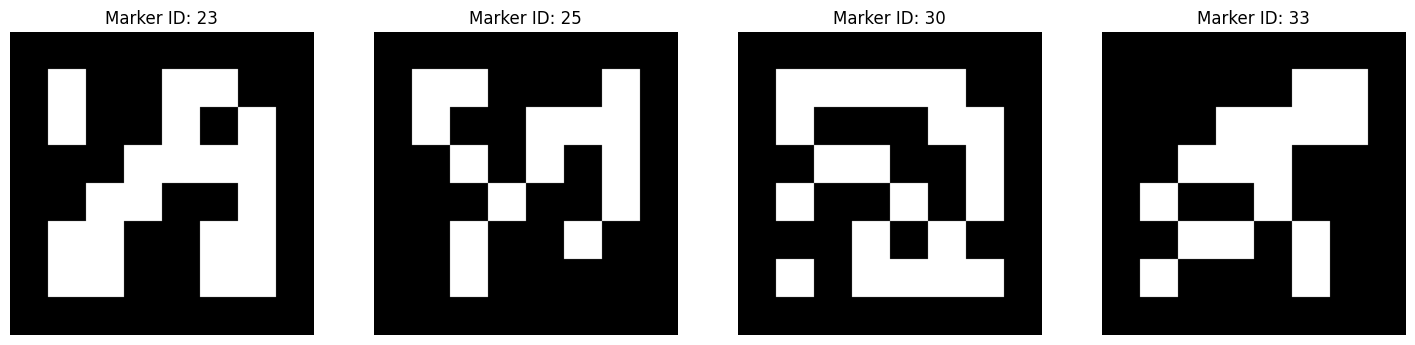

In [3]:
marker_image1 = cv2.aruco.generateImageMarker(dictionary, 23, 200)
marker_image2 = cv2.aruco.generateImageMarker(dictionary, 25, 200)
marker_image3 = cv2.aruco.generateImageMarker(dictionary, 30, 200)
marker_image4 = cv2.aruco.generateImageMarker(dictionary, 33, 200)

# Display the markers.
plt.figure(figsize = [18, 10])
plt.subplot(1,4,1); plt.imshow(marker_image1); plt.title("Marker ID: 23"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(marker_image2); plt.title("Marker ID: 25"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(marker_image3); plt.title("Marker ID: 30"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(marker_image4); plt.title("Marker ID: 33"); plt.axis('off')


In [4]:
cv2.imwrite("markers/marker_23.png", marker_image1)
cv2.imwrite("markers/marker_25.png", marker_image2)
cv2.imwrite("markers/marker_30.png", marker_image3)
cv2.imwrite("markers/marker_33.png", marker_image4)

True

In [5]:
# Read input image with the markers.
frame = cv2.imread('images\IMG_20240903_214327.jpg')

# Detect the markers in the destination image.
corners, ids, rejected = cv2.aruco.detectMarkers(frame, dictionary)

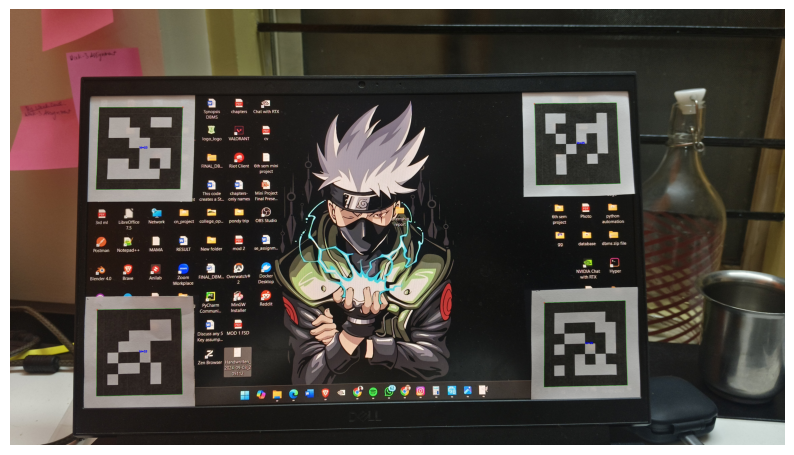

In [6]:
cv2.aruco.drawDetectedMarkers(frame, corners, ids)
plt.figure(figsize = [10,10])
plt.axis('off')
plt.imshow(frame[:,:,::-1])

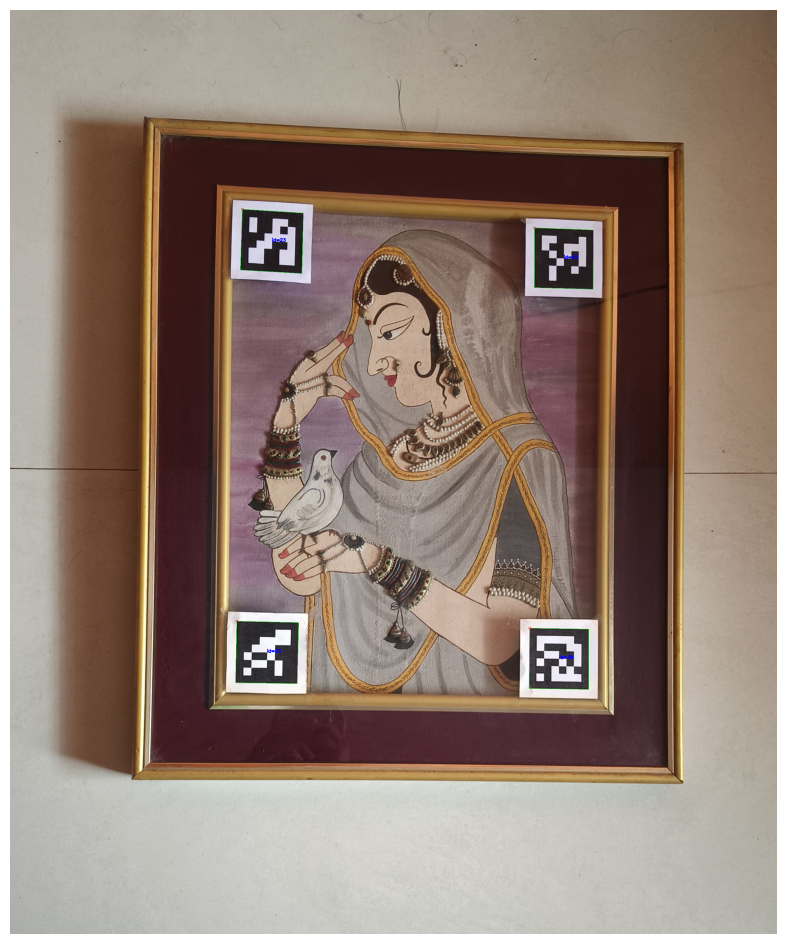

In [32]:
# Read input image with the markers.
frame_dst = cv2.imread('images\IMG_20240904_092026.jpg')

# Detect the markers in the destination image.
corners, ids, rejected = cv2.aruco.detectMarkers(frame_dst, dictionary)

frame_detetced = frame_dst.copy()

cv2.aruco.drawDetectedMarkers(frame_detetced, corners, ids)
plt.figure(figsize = [12,12])
plt.axis('off')
plt.imshow(frame_detetced[:,:,::-1])

In [33]:
# Extract reference point coordinates from marker corners.

# Upper-left corner of ROI.
index = np.squeeze(np.where(ids == 23))
ref_pt1 = np.squeeze(corners[index[0]])[0]

# Upper-right corner of ROI.
index = np.squeeze(np.where(ids == 25))
ref_pt2 = np.squeeze(corners[index[0]])[1]

# Lower-right corner of ROI.
index = np.squeeze(np.where(ids == 30))
ref_pt3 = np.squeeze(corners[index[0]])[2]

# Lower-left corner of ROI.
index = np.squeeze(np.where(ids == 33))
ref_pt4 = np.squeeze(corners[index[0]])[3]

In [37]:
# Compute horizontal and vertical distance between markers.
x_distance = np.linalg.norm(ref_pt1 - ref_pt2)
y_distance = np.linalg.norm(ref_pt1 - ref_pt3)

scaling_fac_x = .015  # Scale factor in x (horizontal).
scaling_fac_y = .025 # Scale factor in y (vertical).

delta_x = round(scaling_fac_x * x_distance)
delta_y = round(scaling_fac_y * y_distance)

# Apply the scaling factors to the ArUco Marker reference points to make.
# the final adjustment for the destination points.
pts_dst = [[ref_pt1[0] - delta_x, ref_pt1[1] - delta_y]]
pts_dst = pts_dst + [[ref_pt2[0] + delta_x, ref_pt2[1] - delta_y]]
pts_dst = pts_dst + [[ref_pt3[0] + delta_x, ref_pt3[1] + delta_y]]
pts_dst = pts_dst + [[ref_pt4[0] - delta_x, ref_pt4[1] + delta_y]]

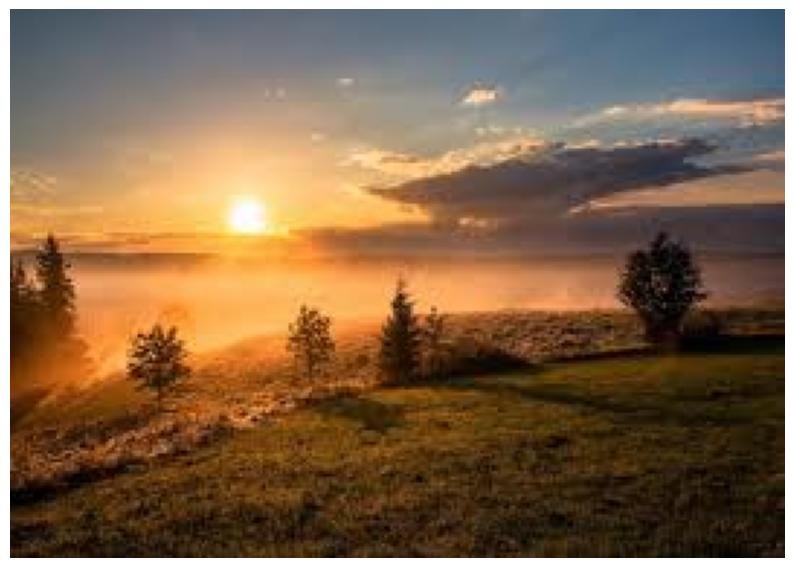

In [38]:
# Read input image with the markers.
frame_src = cv2.imread("above_image_video\\above_image.jpg")
plt.figure(figsize = [10,10])
plt.axis("off")
# plt.show(frame_src)
plt.imshow(cv2.cvtColor(frame_src, cv2.COLOR_BGR2RGB))

# Get the image corners of the source image.
pts_src = [[0,0], [frame_src.shape[1], 0], [frame_src.shape[1], frame_src.shape[0]], [0, frame_src.shape[0]]]
        
pts_src_m = np.asarray(pts_src)
pts_dst_m = np.asarray(pts_dst)

(-0.5, 2591.5, 3122.5, -0.5)

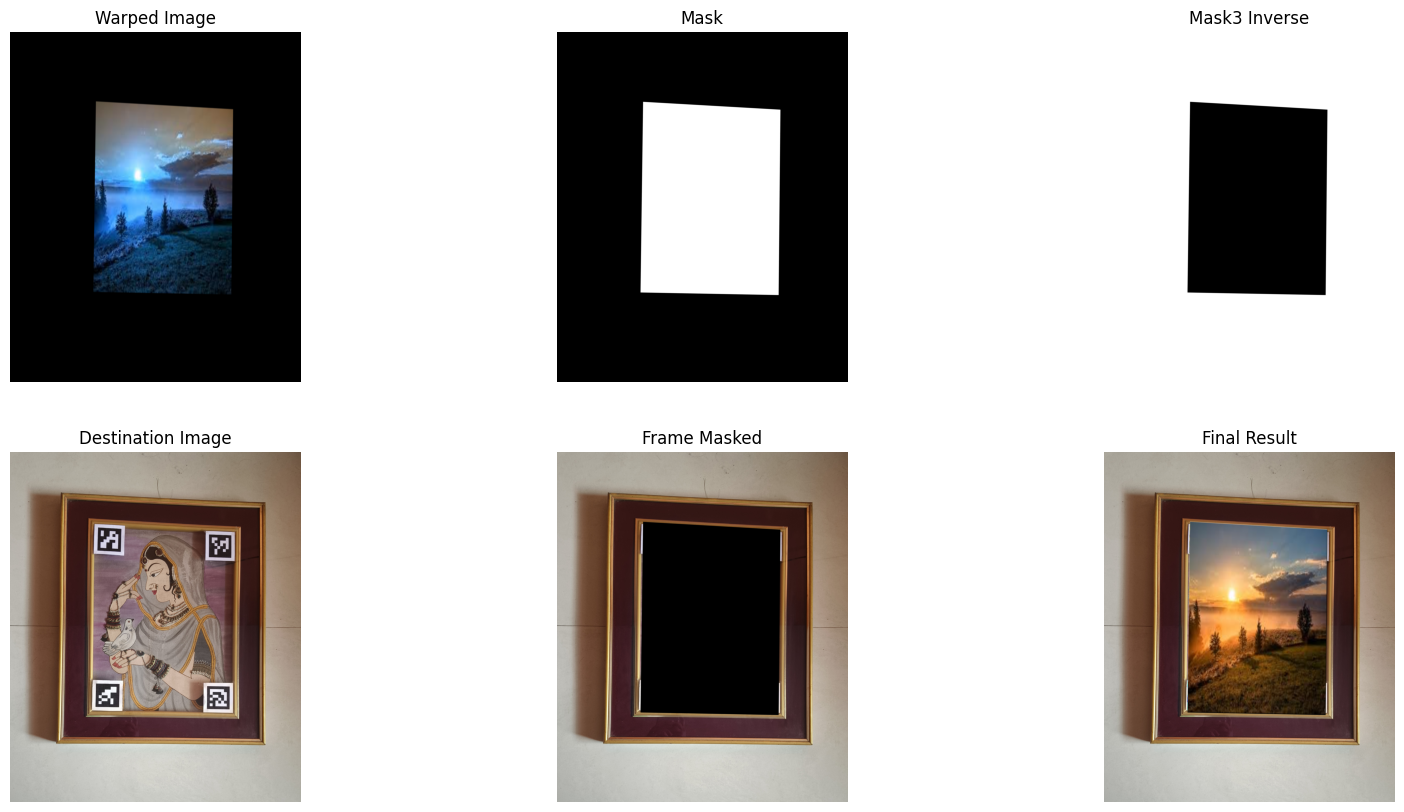

In [39]:
h, mask = cv2.findHomography(pts_src_m, pts_dst_m, cv2.RANSAC)

# Warp source image onto the destination image.
warped_image = cv2.warpPerspective(frame_src, h, (frame_dst.shape[1], frame_dst.shape[0]))

warped_image_copy = warped_image.copy() # Save for display below.

# Prepare a mask representing the region to copy from the warped image into the destination frame.
mask = np.zeros([frame_dst.shape[0], frame_dst.shape[1]], dtype=np.uint8)

# Fill ROI in destination frame with white to create mask.
cv2.fillConvexPoly(mask, np.int32([pts_dst_m]), (255, 255, 255), cv2.LINE_AA)

# Copy the mask into 3 channels.
warped_image = warped_image.astype(float)
mask3 = np.zeros_like(warped_image)
for i in range(0, 3):
    mask3[:, :, i] = mask / 255

# Create inverse mask.
mask3_inv = 1 - mask3

# Create black region in destination frame ROI.
frame_masked = cv2.multiply(frame_dst.astype(float), mask3_inv)

# Create final result by adding the warped image with the masked destination frame.
frame_out = cv2.add(warped_image, frame_masked)

frame_masked = np.uint8(frame_masked)  # For display below.
frame_out = frame_out.astype(np.uint8) # For display below.

plt.figure(figsize = [20,10])
plt.subplot(2,3,1); plt.imshow(warped_image_copy);        plt.title('Warped Image');      plt.axis('off')
plt.subplot(2,3,2); plt.imshow(mask);                     plt.title('Mask');              plt.axis('off')
plt.subplot(2,3,3); plt.imshow(mask3_inv);                plt.title('Mask3 Inverse');     plt.axis('off')
plt.subplot(2,3,4); plt.imshow(frame_dst[:, :, ::-1]);    plt.title('Destination Image'); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(frame_masked[:, :, ::-1]); plt.title('Frame Masked');      plt.axis('off')
plt.subplot(2,3,6); plt.imshow(frame_out[:, :, ::-1]);    plt.title('Final Result');      plt.axis('off')